In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import os


In [2]:
print(torch.__version__)

1.8.1+cu102


In [3]:
#Define activation function beforehand, due to convenience to use later

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

In [4]:
#Pytorch does not have the ‘auto’ padding in Conv2d
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)    

##### Fundamental residual bolck

In [5]:
# If their sizes mismatch, then the input goes into an identity
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

##### Allow to increase out_channels and define shorcut

## ResNetResidualBlock : 1x1/ 3x3/ 1x1

In [6]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):#=conv3x3
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

##### Combine Convolution and BN Layer

In [7]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

## ResNetBasicBlock: 由兩層 3x3conv/batchnorm/activation 組成

In [8]:
class ResNetBasicBlock(ResNetResidualBlock):
    
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [8]:

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )


## ResNetLayer

In [9]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):#代表有n 個 blocks
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

## ResNet Encoder 

In [10]:
class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

## ResnetDecoder

In [11]:
class ResnetDecoder(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

# ResNet

In [12]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

# dataloader

In [14]:
from torch.utils.data import Dataset

class TVDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #sample = {'image': dataset[idx][0], 'label': dataset[idx][1]}
 
        if self.transform:
            image = self.transform(dataset[idx][0])
        #labels=torch.tensor(labels, dtype=torch.long) 
        return (image,dataset[idx][1])

In [23]:
import glob
train_labels=[]
#TRAIN_DATA_PATH = 'traindata/'
#TEST_BATA_PATH='testdata/'

#Airplanes
train_images = glob.glob ('traindata/airplane/*')
airplane_num=len(train_images)
for i in range(airplane_num):
    train_labels.extend([0])
    
#Bird
train_images += glob.glob ('traindata/bird/*')
bird_num=len(train_images)-airplane_num
for i in range(bird_num):
    train_labels.extend([1])
    
#Car
train_images += glob.glob ('traindata/car/*')
car_num=len(train_images) - airplane_num - bird_num
for i in range(car_num):
    train_labels.extend([2])

#Cat
train_images += glob.glob ('traindata/cat/*')
cat_num=len(train_images) - airplane_num - bird_num - car_num
for i in range(cat_num):
    train_labels.extend([3])

#Dog
train_images += glob.glob ('traindata/dog/*')
dog_num=len(train_images) - airplane_num - bird_num - car_num - cat_num
for i in range(dog_num):
    train_labels.extend([4])
    
#Horse
#train_images += glob.glob ('traindata/horse/*.png')
#train_images += glob.glob ('traindata/horse/*.jpg')
#train_images += glob.glob ('traindata/horse/*.jpeg')
train_images += glob.glob ('traindata/horse/*')
horse_num=len(train_images) - airplane_num - bird_num - car_num - cat_num - dog_num
for i in range(horse_num):
    train_labels.extend([5])
    

In [16]:
len(train_images)

13065

In [24]:
import random
c = list(zip(train_images, train_labels))

random.shuffle(c)

train_images, train_labels = zip(*c)

In [18]:
from torch.utils.data import Dataset
from PIL import Image
class New_TVDataset(Dataset):
    def __init__(self, imagelist,labellist, transform=None):
        self.image_list = imagelist
        self.label_list = labellist
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #sample = {'image': dataset[idx][0], 'label': dataset[idx][1]}
        image = Image.open(self.image_list[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        #labels=torch.tensor(labels, dtype=torch.long) 
        return (image, self.label_list[idx])

In [25]:
transform = transforms.Compose([transforms.Resize((96,96)),
                                transforms.RandomHorizontalFlip(p=0.9),transforms.RandomVerticalFlip(p=0.9),
                                transforms.ColorJitter(brightness=(0, 5), contrast=(0, 5), saturation=(0, 5), hue=(-0.1, 0.1)),
                                transforms.RandomRotation(30, expand=False, center=(48, 48)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                ])

transform1 = transforms.Compose([transforms.Resize((96,96)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                ])
#transforms.Grayscale()

ratio =0.8
TOTAL_SIZE= len(train_images)
train_len = round(TOTAL_SIZE * ratio)
valid_len = round(TOTAL_SIZE * (1-ratio))
val_images=train_images[train_len:]
val_labels=train_labels[train_len:]
tr_images=train_images[:train_len]
tr_labels=train_labels[:train_len]
train_dataset=New_TVDataset(tr_images,tr_labels,transform)
val_dataset=New_TVDataset(val_images,val_labels,transform1)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False) 

In [76]:
'''
from torch.utils.data.sampler import SubsetRandomSampler
transform = transforms.Compose([transforms.Resize((96,96)),
                                transforms.RandomHorizontalFlip(p=0.9),transforms.RandomVerticalFlip(p=0.9),
                                transforms.ColorJitter(brightness=(0, 5), contrast=(0, 5), saturation=(0, 5), hue=(-0.1, 0.1)),
                                transforms.RandomRotation(30, expand=False, center=(48, 48)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)),
                                transforms.Grayscale()])
transform1 = transforms.Compose([transforms.Resize((96,96)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)),
                                transforms.Grayscale()])


ratio =0.8
TOTAL_SIZE= len(dataset)
train_len = round(TOTAL_SIZE * ratio)
valid_len = round(TOTAL_SIZE * (1-ratio))

#dataset = datasets.ImageFolder('traindata/',transform=None)





train_dataset, val_dataset = data.random_split(dataset, [train_len, valid_len])
train_dataset=TVDataset(train_dataset,transform)
val_dataset=TVDataset(val_dataset,transform1)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False) 
#transformed_dataset = datasets.ImageFolder('traindata/', transform=transform)
#dataset = torch.utils.data.ConcatDataset([transformed_dataset,origin_dataset])
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
#,transforms.RandomCrop((50,50))  
#transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)),
'''

In [42]:
image,label=next(iter(val_data_loader))


In [43]:
image.mode

<function Tensor.mode>

tensor(0)


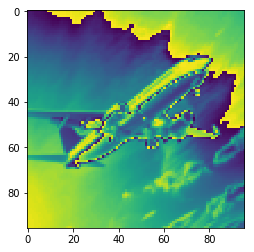

In [27]:
n=1
#plt.imshow((np.transpose(image[n].numpy(), (1, 2, 0)).squeeze()* 255).astype('uint8'))
print(label[n])

### Train & Valid

In [20]:
# I have written the function for you this time, but it's strongly recommended that you 
# understand how to do training and validation
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, data_loader, optimizer, epoch,scheduler, verbose=True):
    model.train()
    loss_avg = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        
        # loss function
        criterion  = nn.CrossEntropyLoss()
        loss   = criterion (output, target)
        loss_avg += loss.item()
        
        # do back propagation
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        
        #print
        #verbose_step = len(data_loader) // 10
        verbose_step=100
        if batch_idx % verbose_step == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
    return loss_avg / len(data_loader)

def valid(model, data_loader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        correct = 0
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #00
            criterion  = nn.CrossEntropyLoss()
            loss   = criterion (output, target)
            loss_avg = loss.item()
            valid_loss +=loss_avg  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item() 

        #valid_loss /= len(data_loader.dataset)
        valid_loss /= len(data_loader)
        print('Valid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            valid_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
    return float(correct) / len(data_loader.dataset)

In [14]:
model=resnet18(3,6)
model.to(device=device)

In [ ]:
####################  implement your optimizer ###################################
## yo can use any training methods if you want (ex:lr decay, weight decay.....)

lr=0.001
#optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=10, min_lr=0.000001, eps=1e-08, threshold=0.0001, threshold_mode='rel', cooldown=0, verbose=True)
# start training
epochs = 600
acc = 0.95
for epoch in range(epochs):
    #model.train()
    loss = train(model, train_data_loader, optimizer, epoch,scheduler)
    print('-> Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss))
    accuracy = valid(model, val_data_loader)
    scheduler.step(loss)
    if accuracy > acc:
        acc = accuracy
        print("-------------saving model--------------")
        # save the model
        torch.save(model, "model.pth")

Train Epoch: 0 [0/10451 (0%)]	Loss: 1.788399
Train Epoch: 0 [3200/10451 (31%)]	Loss: 1.670528


/home/NFS/course/mlintro/mlintro2021s/mlintro2021s21/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/NFS/course/mlintro/mlintro2021s/mlintro2021s21/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/NFS/course/mlintro/mlintro2021s/mlintro2021s21/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/NFS/course/mlintro/mlintro2021s/mlintro2021s21/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 byt

Train Epoch: 0 [6400/10451 (61%)]	Loss: 1.628653
Train Epoch: 0 [9600/10451 (92%)]	Loss: 1.470517
-> Train Epoch: 0 	Loss: 1.584734
Valid set: Average loss: 1.5932, Accuracy: 948/2613 (36%)

Train Epoch: 1 [0/10451 (0%)]	Loss: 1.393530
Train Epoch: 1 [3200/10451 (31%)]	Loss: 1.449840
Train Epoch: 1 [6400/10451 (61%)]	Loss: 1.657221
Train Epoch: 1 [9600/10451 (92%)]	Loss: 1.368242
-> Train Epoch: 1 	Loss: 1.453207
Valid set: Average loss: 1.5510, Accuracy: 1000/2613 (38%)

Train Epoch: 2 [0/10451 (0%)]	Loss: 1.599807
Train Epoch: 2 [3200/10451 (31%)]	Loss: 1.439816
Train Epoch: 2 [6400/10451 (61%)]	Loss: 1.391903
Train Epoch: 2 [9600/10451 (92%)]	Loss: 1.147650
-> Train Epoch: 2 	Loss: 1.361415
Valid set: Average loss: 1.4287, Accuracy: 1093/2613 (42%)

Train Epoch: 3 [0/10451 (0%)]	Loss: 1.331752
Train Epoch: 3 [3200/10451 (31%)]	Loss: 1.183051
Train Epoch: 3 [6400/10451 (61%)]	Loss: 1.370685
Train Epoch: 3 [9600/10451 (92%)]	Loss: 1.362253
-> Train Epoch: 3 	Loss: 1.295260
Valid set: 

-> Train Epoch: 28 	Loss: 0.692832
Valid set: Average loss: 1.0240, Accuracy: 1635/2613 (63%)

Train Epoch: 29 [0/10451 (0%)]	Loss: 0.512225
Train Epoch: 29 [3200/10451 (31%)]	Loss: 0.864634
Train Epoch: 29 [6400/10451 (61%)]	Loss: 0.547598
Train Epoch: 29 [9600/10451 (92%)]	Loss: 0.690355
-> Train Epoch: 29 	Loss: 0.677227
Valid set: Average loss: 0.9876, Accuracy: 1685/2613 (64%)

Train Epoch: 30 [0/10451 (0%)]	Loss: 0.726129
Train Epoch: 30 [3200/10451 (31%)]	Loss: 0.611961
Train Epoch: 30 [6400/10451 (61%)]	Loss: 0.696621
Train Epoch: 30 [9600/10451 (92%)]	Loss: 0.696360
-> Train Epoch: 30 	Loss: 0.662391
Valid set: Average loss: 0.9834, Accuracy: 1671/2613 (64%)

Train Epoch: 31 [0/10451 (0%)]	Loss: 0.527964
Train Epoch: 31 [3200/10451 (31%)]	Loss: 0.730242
Train Epoch: 31 [6400/10451 (61%)]	Loss: 0.615253
Train Epoch: 31 [9600/10451 (92%)]	Loss: 0.778864
-> Train Epoch: 31 	Loss: 0.662459
Valid set: Average loss: 0.9826, Accuracy: 1646/2613 (63%)

Train Epoch: 32 [0/10451 (0%)]	L

Train Epoch: 57 [0/10451 (0%)]	Loss: 0.307328
Train Epoch: 57 [3200/10451 (31%)]	Loss: 0.272944
Train Epoch: 57 [6400/10451 (61%)]	Loss: 0.594661
Train Epoch: 57 [9600/10451 (92%)]	Loss: 0.495173
-> Train Epoch: 57 	Loss: 0.455004
Valid set: Average loss: 0.9072, Accuracy: 1808/2613 (69%)

Train Epoch: 58 [0/10451 (0%)]	Loss: 0.347437
Train Epoch: 58 [3200/10451 (31%)]	Loss: 0.521036
Train Epoch: 58 [6400/10451 (61%)]	Loss: 0.495522
Train Epoch: 58 [9600/10451 (92%)]	Loss: 0.547999
-> Train Epoch: 58 	Loss: 0.446191
Valid set: Average loss: 0.8207, Accuracy: 1878/2613 (72%)

Train Epoch: 59 [0/10451 (0%)]	Loss: 0.320202
Train Epoch: 59 [3200/10451 (31%)]	Loss: 0.275495
Train Epoch: 59 [6400/10451 (61%)]	Loss: 0.629117
Train Epoch: 59 [9600/10451 (92%)]	Loss: 0.398884
-> Train Epoch: 59 	Loss: 0.443622
Valid set: Average loss: 0.9150, Accuracy: 1821/2613 (70%)

Train Epoch: 60 [0/10451 (0%)]	Loss: 0.415683
Train Epoch: 60 [3200/10451 (31%)]	Loss: 0.491049
Train Epoch: 60 [6400/10451 (61

Train Epoch: 85 [3200/10451 (31%)]	Loss: 0.207593
Train Epoch: 85 [6400/10451 (61%)]	Loss: 0.457414
Train Epoch: 85 [9600/10451 (92%)]	Loss: 0.297357
-> Train Epoch: 85 	Loss: 0.363202
Valid set: Average loss: 0.8302, Accuracy: 1917/2613 (73%)

Train Epoch: 86 [0/10451 (0%)]	Loss: 0.511828
Train Epoch: 86 [3200/10451 (31%)]	Loss: 0.241247
Train Epoch: 86 [6400/10451 (61%)]	Loss: 0.257316
Train Epoch: 86 [9600/10451 (92%)]	Loss: 0.646910
-> Train Epoch: 86 	Loss: 0.356624
Valid set: Average loss: 0.8279, Accuracy: 1908/2613 (73%)

Train Epoch: 87 [0/10451 (0%)]	Loss: 0.306411
Train Epoch: 87 [3200/10451 (31%)]	Loss: 0.221371
Train Epoch: 87 [6400/10451 (61%)]	Loss: 0.305745
Train Epoch: 87 [9600/10451 (92%)]	Loss: 0.622052
-> Train Epoch: 87 	Loss: 0.354489
Valid set: Average loss: 0.7558, Accuracy: 1951/2613 (75%)

Train Epoch: 88 [0/10451 (0%)]	Loss: 0.417594
Train Epoch: 88 [3200/10451 (31%)]	Loss: 0.350899
Train Epoch: 88 [6400/10451 (61%)]	Loss: 0.437475
Train Epoch: 88 [9600/10451

Train Epoch: 113 [3200/10451 (31%)]	Loss: 0.324471
Train Epoch: 113 [6400/10451 (61%)]	Loss: 0.111526
Train Epoch: 113 [9600/10451 (92%)]	Loss: 0.074086
-> Train Epoch: 113 	Loss: 0.315506
Valid set: Average loss: 0.6982, Accuracy: 2007/2613 (77%)

Train Epoch: 114 [0/10451 (0%)]	Loss: 0.218804
Train Epoch: 114 [3200/10451 (31%)]	Loss: 0.453606
Train Epoch: 114 [6400/10451 (61%)]	Loss: 0.357080
Train Epoch: 114 [9600/10451 (92%)]	Loss: 0.118776
-> Train Epoch: 114 	Loss: 0.302097
Valid set: Average loss: 0.7447, Accuracy: 1992/2613 (76%)

Train Epoch: 115 [0/10451 (0%)]	Loss: 0.314632
Train Epoch: 115 [3200/10451 (31%)]	Loss: 0.330005
Train Epoch: 115 [6400/10451 (61%)]	Loss: 0.303933
Train Epoch: 115 [9600/10451 (92%)]	Loss: 0.286043
-> Train Epoch: 115 	Loss: 0.314509
Valid set: Average loss: 0.7710, Accuracy: 1980/2613 (76%)

Train Epoch: 116 [0/10451 (0%)]	Loss: 0.315657
Train Epoch: 116 [3200/10451 (31%)]	Loss: 0.170874
Train Epoch: 116 [6400/10451 (61%)]	Loss: 0.235061
Train Epoc

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model so that you don't need to train the model again
test_model = torch.load("model.pth").to(device)

In [49]:
import glob
image_list = []
for filename in glob.glob('testdata/*.png'):
    image_list.append(filename)
image_list.sort()


In [50]:
from torch.utils.data import Dataset
import imageio
from PIL import Image


class TestDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        #self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
                                #self.landmarks_frame.iloc[idx, 0])
        #image = imageio.imread(self.image_list[idx])
        im = Image.open(self.image_list[idx])
        #sample = {'image': image}
        if self.transform:
            im = self.transform(im)

        return im

In [51]:
test_dataset=TestDataset(image_list,transform1)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
def test(model,data_loader,image_list):
    with torch.no_grad():
        num=0
        model.eval()
        valid_loss = 0
        correct = 0
        bs = test_data_loader.batch_size
        result = []
        for i, data in enumerate(test_data_loader):
            data = data.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]                                             # get the index of the max log-probability
            arr = pred.data.cpu().numpy()
            for j in range(pred.size()[0]):
                #file_name = test_data.samples[i*bs+j][0].split('/')[-1]
                file_name = image_list[num].split('/')[-1]
                result.append((file_name,pred[j].cpu().numpy()[0]))
                num+=1
    return result

In [53]:
result = test(model,test_data_loader,image_list)

In [ ]:
############## Build the model here ##########
'''
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
    
        super(ConvNet, self).__init__()
    
        

    def forward(self, x):
        
        return out
'''



# Write results to csv

In [54]:
import csv

with open("prediction_0428.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(['Id','Category'])
    #for row in result:
    #    writer.writerows(row)
    writer.writerows(result)

In [16]:

'''
import glob
train_labels=[]
#TRAIN_DATA_PATH = 'traindata/'
#TEST_BATA_PATH='testdata/'

#Airplanes
train_images = glob.glob ('traindata/airplane/*.png')
airplane_num=len(train_images)
for i in range(airplane_num):
    train_labels.extend([0])
#Bird
train_images += glob.glob ('traindata/bird/*.png')
bird_num=len(train_images)-airplane_num
for i in range(bird_num):
    train_labels.extend([1])
    
#Car
train_images += glob.glob ('traindata/car/*.png')
car_num=len(train_images) - airplane_num - bird_num
for i in range(car_num):
    train_labels.extend([2])

#Cat
train_images += glob.glob ('traindata/cat/*.png')
cat_num=len(train_images) - airplane_num - bird_num - car_num
for i in range(cat_num):
    train_labels.extend([3])

#Dog
train_images += glob.glob ('traindata/dog/*.png')
dog_num=len(train_images) - airplane_num - bird_num - car_num - cat_num
for i in range(dog_num):
    train_labels.extend([4])
    
#Dog
train_images += glob.glob ('traindata/horse/*.png')
horse_num=len(train_images) - airplane_num - bird_num - car_num - cat_num - dog_num
for i in range(horse_num):
    train_labels.extend([5])
    
    
'''

In [16]:
from torch.utils.data import Dataset

'''
class ImageDataset(Dataset):

    def __init__(self, data_root):
        self.samples = []
        num=0
        for objects in os.listdir(data_root): #animals=airplane, bird, car...
            objects_folder = os.path.join(data_root, objects)

            for categ in os.listdir(objects_folder):
                categ_filepath = os.path.join(animals_folder, categ)
                self.samples.append()
        self.transform = transforms.Compose([transforms.Resize(255),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
'''

'\nclass ImageDataset(Dataset):\n\n    def __init__(self, data_root):\n        self.samples = []\n        num=0\n        for objects in os.listdir(data_root): #animals=airplane, bird, car...\n            objects_folder = os.path.join(data_root, objects)\n\n            for categ in os.listdir(objects_folder):\n                categ_filepath = os.path.join(animals_folder, categ)\n                self.samples.append()\n        self.transform = transforms.Compose([transforms.Resize(255),\n                                             transforms.CenterCrop(224),\n                                             transforms.ToTensor()])\n\n    def __len__(self):\n        return len(self.samples)\n\n    def __getitem__(self, idx):\n        return self.samples[idx]\n'